# Alien detection - CNN
In questo notebook è riportata una CNN costruita al fine di pulire il dataset da immagini fuori contesto: in questo caso immagini del suolo di marte con sovrapposizione della faccia di un alieno.

**Connect Colab to Google Drive**

In [ ]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL/Homework 2


**Import Libraries**

In [ ]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 0


**Load the Data**

In [ ]:
data = np.load("mars_for_students.npz") # stiamo lavorando con array di tipo numpy
print(f"Chiavi disponibili: {list(data.keys())}")

training_set = data["training_set"]
X_train = training_set[:, 0] # immagini
y_train = training_set[:, 1] # maschere

X_test = data["test_set"] # ha solo le immagini

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Chiavi disponibili: ['training_set', 'test_set']
Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


**Osservazione:**
Il dataset contiene il training set e il test set. Il training set è costituito dalle immagini e le relative maschere, mentre il test set è costituito dalle sole immagini.
Tutte le immagini e le maschere sono di dimensioni 64x128 e ne abbiamo 2615 nel training set e 10022 nel test set.

In [ ]:
print(f"Primo elemento di X_train: {X_train[0]}")
print(f"Primo elemento di y_train: {y_train[0]}")
print(f"Tipo di elementi in X_train: {X_train[0].dtype}")
print(f"Tipo di elementi in y_train: {y_train[0].dtype}")

Primo elemento di X_train: [[81. 86. 86. ... 82. 83. 83.]
 [84. 85. 81. ... 77. 77. 80.]
 [85. 85. 84. ... 61. 65. 71.]
 ...
 [69. 73. 76. ... 66. 65. 63.]
 [74. 77. 78. ... 64. 63. 63.]
 [71. 74. 76. ... 65. 66. 70.]]
Primo elemento di y_train: [[2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 [2. 2. 2. ... 2. 2. 2.]
 ...
 [2. 2. 2. ... 0. 0. 0.]
 [2. 2. 2. ... 0. 0. 0.]
 [2. 2. 2. ... 0. 0. 0.]]
Tipo di elementi in X_train: float64
Tipo di elementi in y_train: float64


**Osservazione:** in X_train abbiamo la prima immagine ovvero la prima matrice avente valori da 0 a 255 (le intensità dei pixel). Il primo elemento di y_train invece è una matrice a valori discreti e contiene i labels dei pixel.

In [ ]:
print(f"Valori minimi e massimi di X_train: {X_train.min()}, {X_train.max()}")
print(f"Valori minimi e massimi di X_test: {X_test.min()}, {X_test.max()}")

Valori minimi e massimi di X_train: 2.0, 254.0
Valori minimi e massimi di X_test: 1, 255


**Osservazione:** i valori sono nel range corretto 0-255. Procedo con la normalizzazione sia del train sia del test.

In [ ]:
X_train = (X_train / 255).astype('float32')
X_test = (X_test / 255).astype('float32')

print(f"Valori minimi e massimi di X_train: {X_train.min()}, {X_train.max()}")
print(f"Valori minimi e massimi di X_test: {X_test.min()}, {X_test.max()}")

Valori minimi e massimi di X_train: 0.007843137718737125, 0.9960784316062927
Valori minimi e massimi di X_test: 0.003921568859368563, 1.0


In [ ]:
unique_classes = np.unique(y_train)
print(f"Classi uniche in y_train: {unique_classes}")

Classi uniche in y_train: [0. 1. 2. 3. 4.]


**Osservazione:**

Le classi che ci aspettavamo sono corrette e sono 5:

0: Background

1: Soil

2: Bedrock

3: Sand

4: Big Rock

In [ ]:
# Campioni immagini di test
fig, axes = plt.subplots(20, 10, figsize=(15, 15))
axes = axes.flatten()

# Itero sulle prime 200 immagini del dataset
for i in range(200):
    ax = axes[i]
    ax.imshow(X_test[i], cmap='gray')  # Visualizzo l'immagine
    ax.axis('off')

plt.tight_layout()  # Per evitare sovrapposizioni
plt.show()

Output hidden; open in https://colab.research.google.com to view.

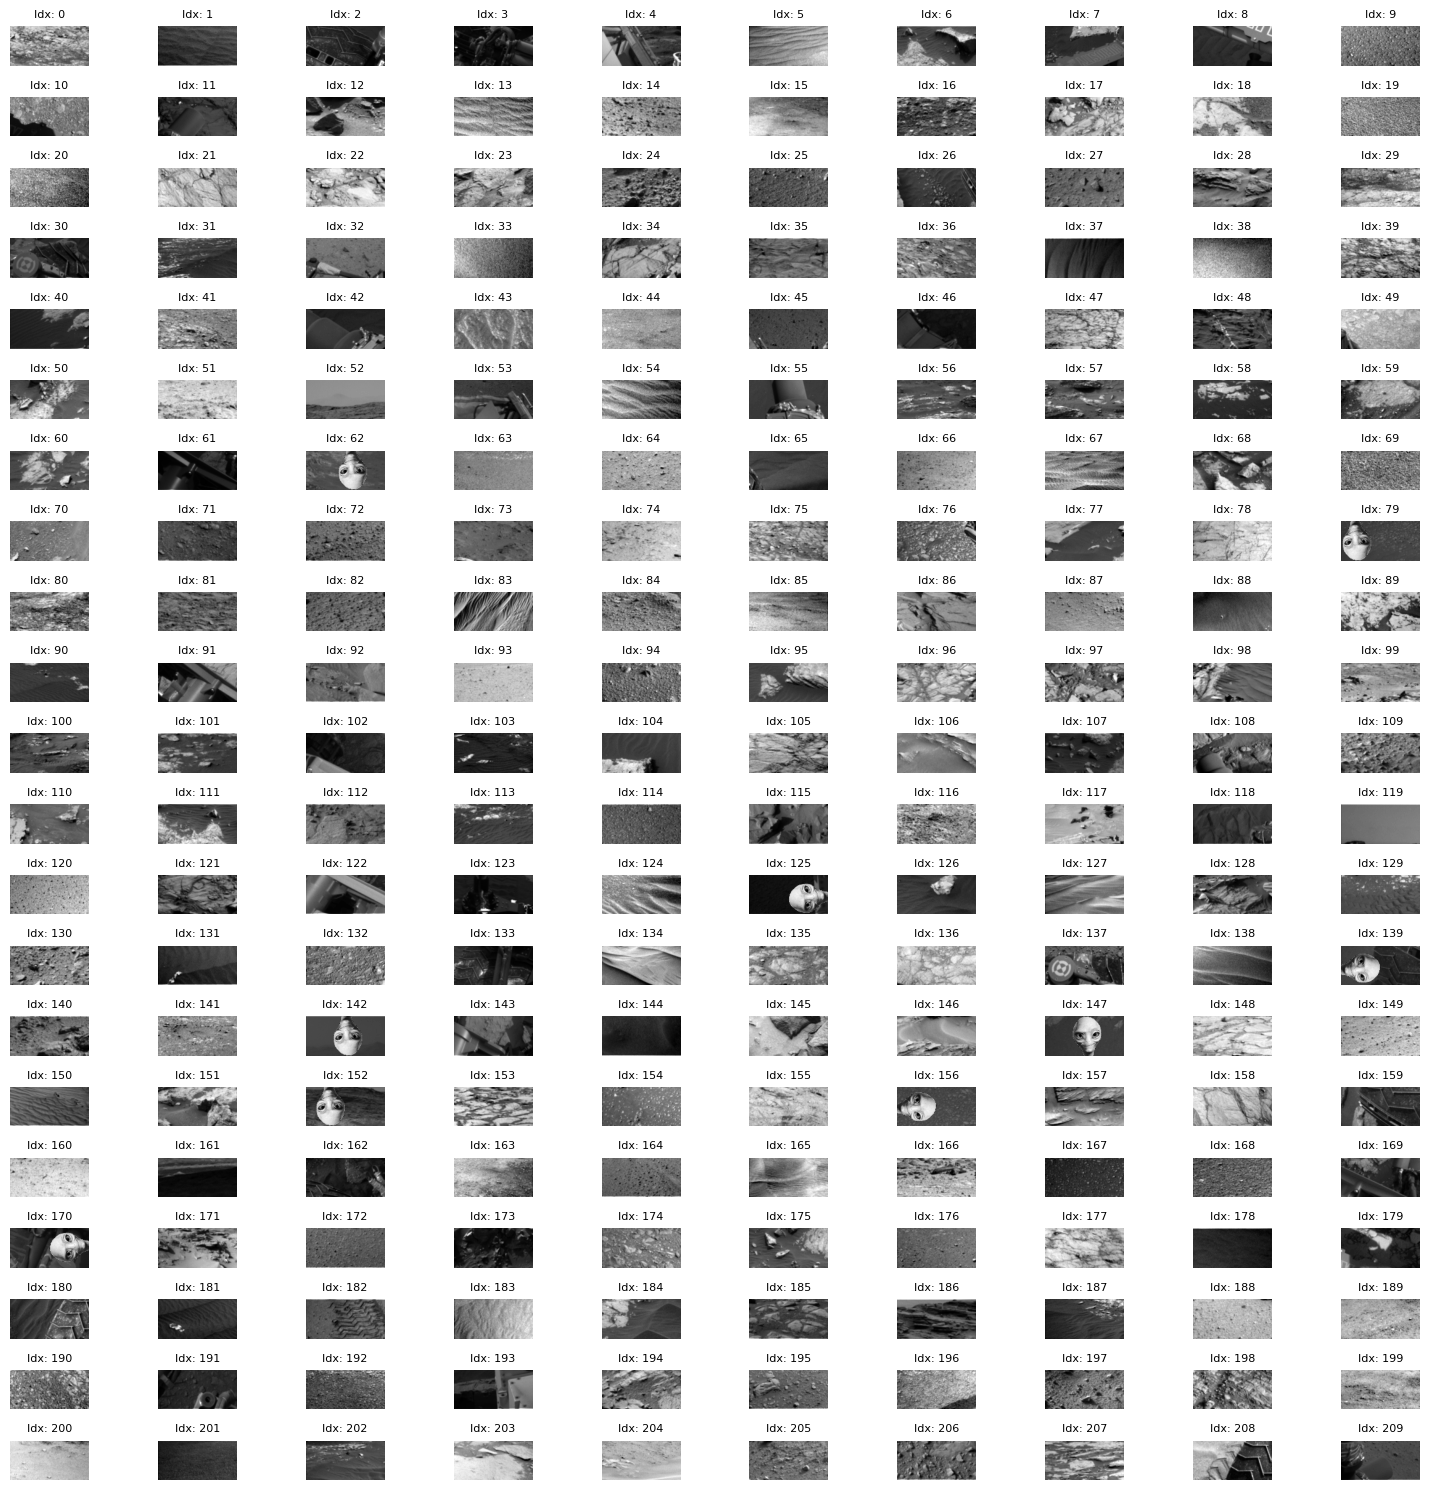

In [ ]:
# Campioni immagini di train
fig, axes = plt.subplots(21, 10, figsize=(15, 15))  # griglia di sottotrame
axes = axes.flatten()

# Itero sulle prime 210 immagini del dataset
for i in range(210):
    ax = axes[i]
    ax.imshow(X_train[i], cmap='gray')  # Visualizzo l'immagine
    ax.axis('off')
    ax.set_title(f"Idx: {i}", fontsize=8)

plt.tight_layout()  # per evitare sovrapposizioni
plt.show()

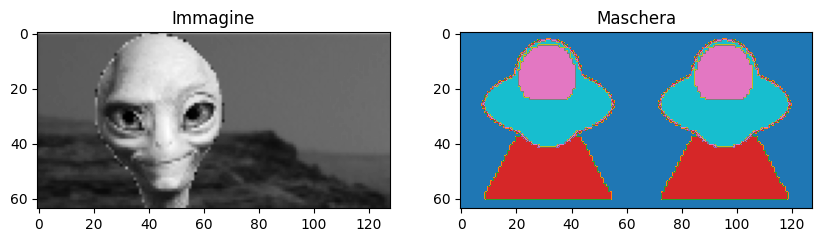

In [ ]:
idx = 2000

plt.figure(figsize=(10, 5))

# visualizzazione immagine
plt.subplot(1, 2, 1)
plt.imshow(X_train[idx], cmap="gray")
plt.title("Immagine")

# visualizzazione maschera
plt.subplot(1, 2, 2)
plt.imshow(y_train[idx], cmap="tab10")  # Uso una mappa di colori per le classi
plt.title("Maschera")

plt.show()

**Osservazione:** questa immagine è fuori contesto rispetto al nostro task ed è stata rilevata dall'analisi visiva del contenuto del training set. Abbiamo quindi la necessità di pulire il dataset.

## Pulizia del dataset



**Creazione del dataset**

In [ ]:
# Creo il dataset di training estraendo delle immagini del suolo pulite e delle immagini con la faccia dell'alieno

mars_selecton = [470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509] # indici terreno indice = 0
alien_selection = [62,79,125,139,142,147,152,156,170] # indici alieni indice = 1
labels = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1]) # indico se sono terreno o alieno

X_mars = X_train[mars_selecton] # estraggo immagini di terreno
X_alien = X_train[alien_selection] # estraggo immagini di alieni

print(X_mars.shape)  # Forma delle immagini di terreno
print(X_alien.shape)  # Forma delle immagini di alieni

(40, 64, 128)
(9, 64, 128)


Label originali: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1]
Label dopo lo shuffle: [0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0]


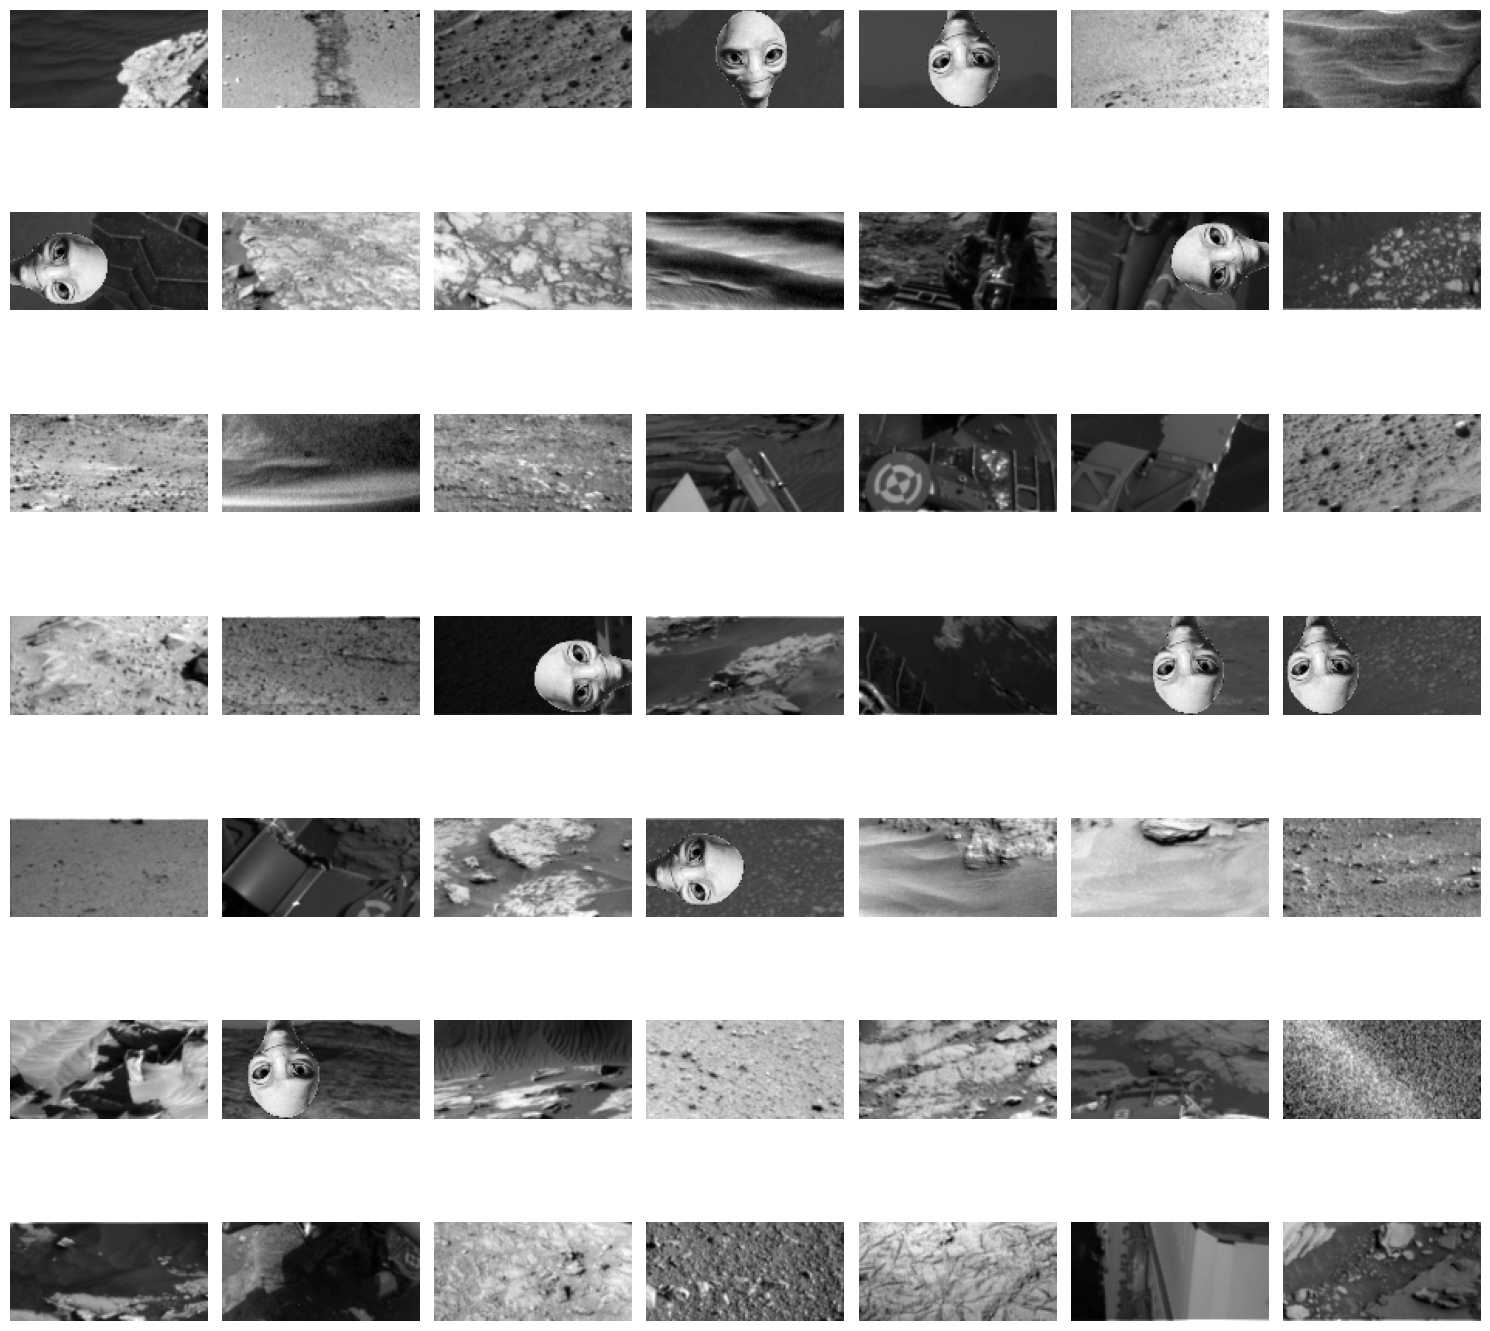

In [ ]:
X_classificator = np.concatenate((X_mars, X_alien), axis=0) # creo il dataset

# mescolo i dati per non avere prima tutto il terreno e poi tutti gli alieni
indices = np.arange(len(X_classificator))
np.random.shuffle(indices)

X_classificator_shuffled = X_classificator[indices] # mescolo le immagini
labels_shuffled = labels[indices] # allo stesso modo mescolo i labels

print("Label originali:", labels)
print("Label dopo lo shuffle:", labels_shuffled)

# visualizzo il dataset
fig, axes = plt.subplots(7, 7, figsize=(15, 15))
axes = axes.flatten()

for i in range(len(X_classificator_shuffled)):
    ax = axes[i]
    ax.imshow(X_classificator_shuffled[i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

**Osservazione:** ho creato il dataset di cui ho bisogno per pulire i dati. Essendo però le due classi sbilanciate calcolo i pesi per il fit del modello.

In [ ]:
# calcolo i pesi per bilanciare le classi nel modello

def compute_class_weights(labels):
    unique_classes, counts = np.unique(labels, return_counts=True) # frequenza per ogni classe
    total_samples = len(labels) # tot campioni
    class_weights = {class_label: total_samples / count for class_label, count in zip(unique_classes, counts)} # pesi inv. prop. al numero di obs per classe
    return class_weights

class_weights = class_weights = compute_class_weights(labels_shuffled)
print(class_weights)

{0: 1.225, 1: 5.444444444444445}


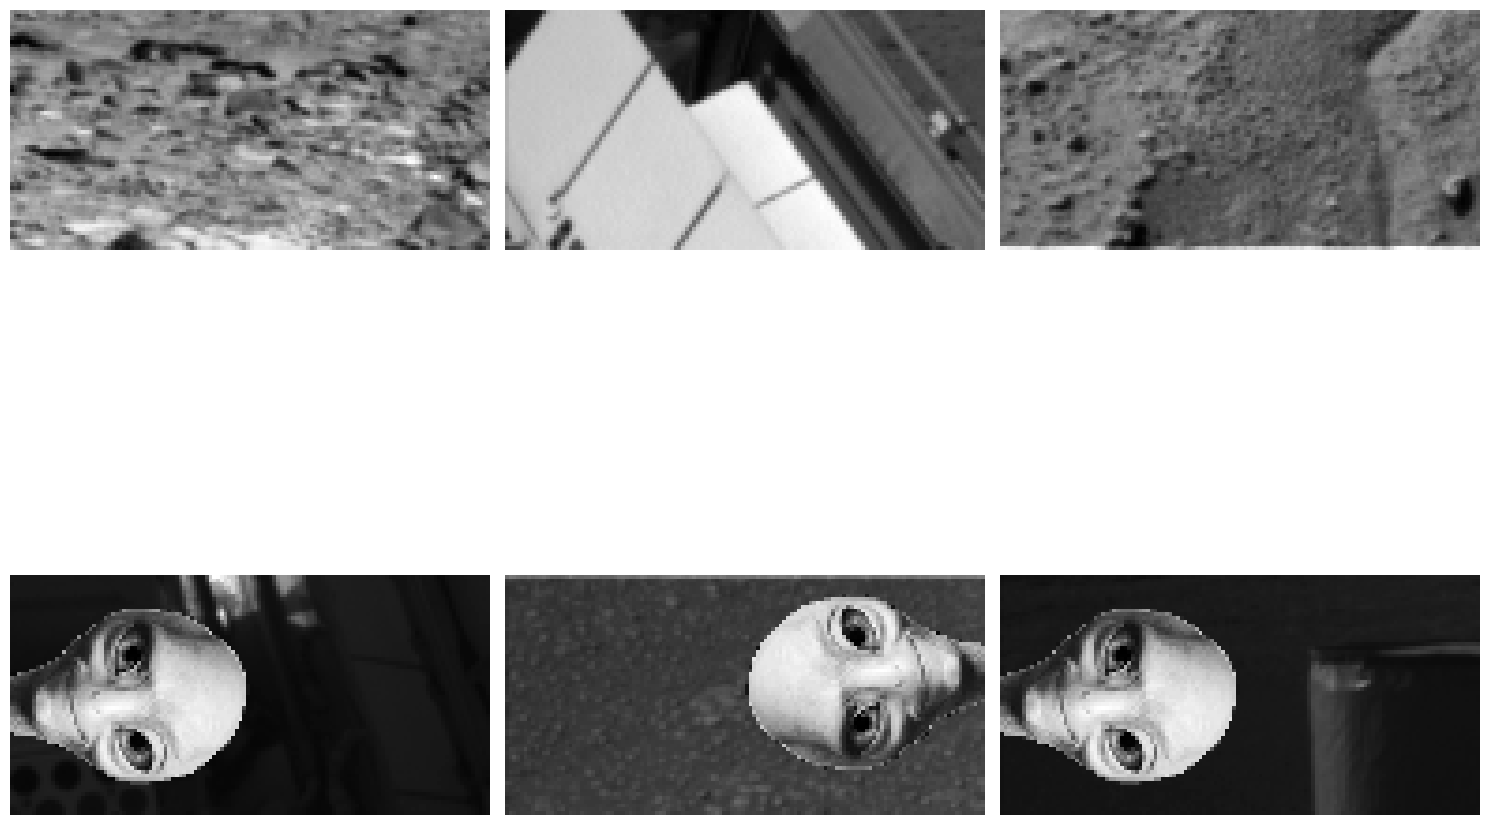

In [ ]:
# Creo il dataset di validazione
mars_val = [454,531,534] # indici terreno, indice = 0
alien_val = [417,450,461] # indici alieni, indice = 1
labels_val = np.array([0,0,0,1,1,1]) # indico se sono terreno o alieno

X_mars_val = X_train[mars_val] # estraggo immagini di terreno
X_alien_val = X_train[alien_val] # estraggo immagini di alieni

X_val = np.concatenate((X_mars_val, X_alien_val), axis=0) # creo il dataset

# visualizzo
fig, axes = plt.subplots(2, 3, figsize=(15, 15))
axes = axes.flatten()
for i in range(6):
    ax = axes[i]
    ax.imshow(X_val[i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Costruzione CNN
Una volta creato il dataset posso passare alla definizione dei parametri del modello e alla costruzione del modello stesso.

In [ ]:
input_shape = (64,128,1) # 64x128 e 1 channel (bianco e nero)

output_shape = 2 # classificazione binaria

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (64, 128, 1)
Output Shape: 2


In [ ]:
epochs = 20

batch_size = 4

learning_rate = 0.001

print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rare:", learning_rate)

Epochs: 20
Batch Size: 4
Learning Rare: 0.001


In [ ]:
def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=learning_rate,
    seed=seed
):
    tf.random.set_seed(seed)

    # input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # primo blocco convoluzionale
    x = tfkl.Conv2D(filters=16, kernel_size=5, padding='same', name='conv1')(input_layer) # collegamento del primo layer chiamato conv1 all'input layer
    x = tfkl.Activation('relu', name='act1')(x) # funzione di attivazione
    x = tfkl.MaxPooling2D(pool_size=2, name='mp1')(x) # max pooling

    # secondo blocco
    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv2')(x)
    x = tfkl.Activation('relu', name='act2')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp2')(x)

    # terzo blocco
    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv3')(x)
    x = tfkl.Activation('relu', name='act3')(x)
    x = tfkl.MaxPooling2D(pool_size=2, name='mp3')(x)

    x = tfkl.Flatten(name='flatten')(x) # appiattimento

    x = tfkl.Dense(units=output_shape, name='dense')(x) # classificatore
    outputs = tfkl.Activation('softmax', name='softmax')(x)

    # Connessione dell'input e dell'output tramite il modello
    model = tfk.Model(inputs=input_layer, outputs=outputs, name='CNN')

    # Compilazione
    loss = tfk.losses.SparseCategoricalCrossentropy()
    optimizer = tfk.optimizers.Adam(learning_rate)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 64, 128, 1)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv1 (Conv2D)                      │ (None, 64, 128, 16)          │           416 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act1 (Activation)                   │ (None, 64, 128, 16)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp1 (MaxPooling2D)                  │ (None, 32, 64, 16)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2 (Conv2D)                      │ (None, 32, 64, 32)           │         4,640 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act2 (Activation)                   │ (None, 32, 64, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp2 (MaxPooling2D)                  │ (None, 16, 32, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv3 (Conv2D)                      │ (None, 16, 32, 64)           │        18,496 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act3 (Activation)                   │ (None, 16, 32, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp3 (MaxPooling2D)                  │ (None, 8, 16, 64)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ flatten (Flatten)                   │ (None, 8192)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 2)                    │        16,386 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ softmax (Activation)                │ (None, 2)                    │             0 │    -    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 39,938 (156.01 KB)

 Trainable params: 39,938 (156.01 KB)

 Non-trainable params: 0 (0.00 B)

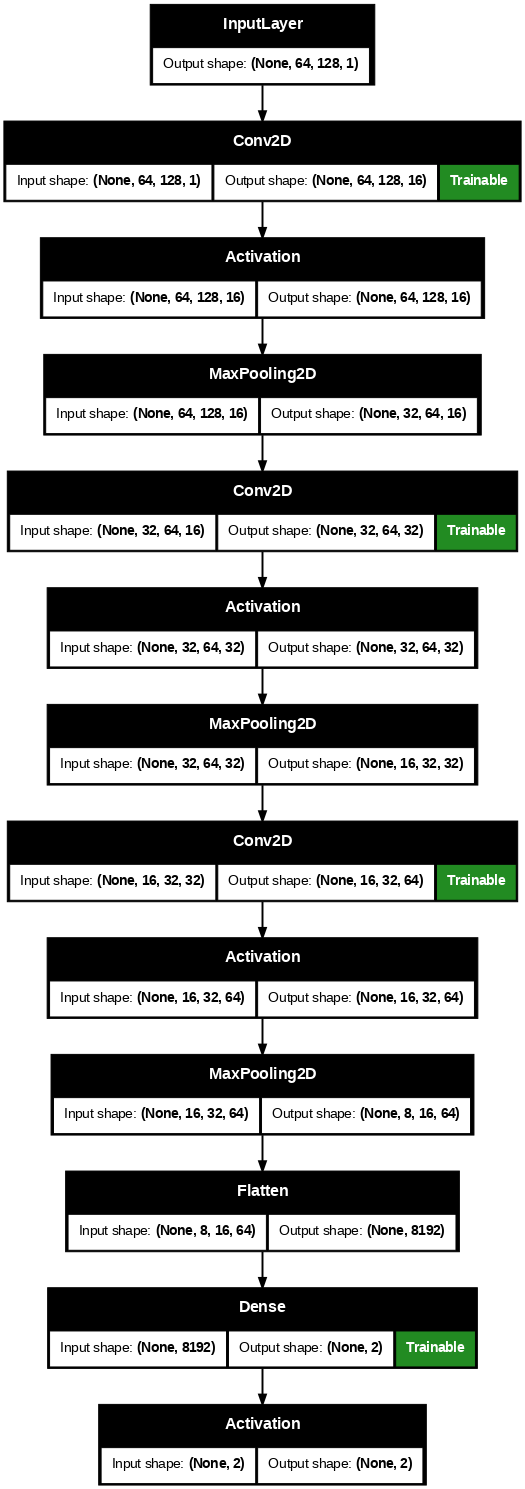

In [ ]:
# Building del modello
model = build_model()

# Summary
model.summary(expand_nested=True, show_trainable=True)

# Plot dell'architettura
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
# parametro per l'early stopping
patience = 15

# EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=patience,
    restore_best_weights=True
)

callbacks = [early_stopping] # applico solo early stopping

In [ ]:
# Train del modello con i callbacks e i pesi calcolati precedentemente
history = model.fit(
    x=X_classificator_shuffled,
    y=labels_shuffled,
    class_weight=class_weights, ### PESI
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, labels_val),
    callbacks=callbacks ### CALLBACKS
).history

final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# salvataggio
model_filename = 'Alien_detector'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.3961 - loss: 1.4497 - val_accuracy: 0.5000 - val_loss: 0.6604
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.1851 - loss: 1.3097 - val_accuracy: 0.6667 - val_loss: 0.5826
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.3919 - loss: 1.1241 - val_accuracy: 0.8333 - val_loss: 0.4514
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8644 - loss: 0.8506 - val_accuracy: 1.0000 - val_loss: 0.2696
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9844 - loss: 0.4280 - val_accuracy: 1.0000 - val_loss: 0.1696
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.1595 - val_accuracy: 0.8333 - val_loss: 0.3208
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.9417 - loss: 0.1540 - val_accuracy: 1.0000 - val_loss: 0.1000
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 0.0232 - val_accuracy: 1.0000 - v

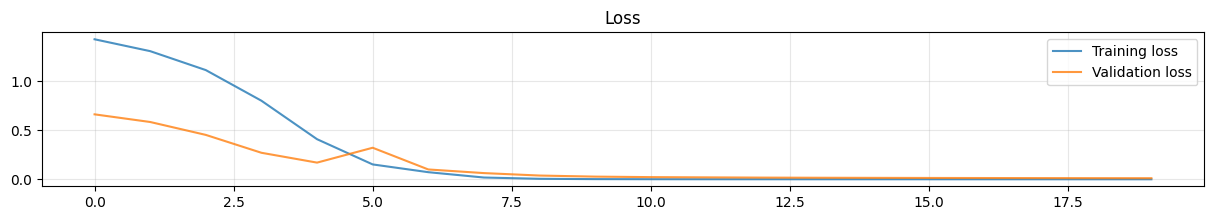

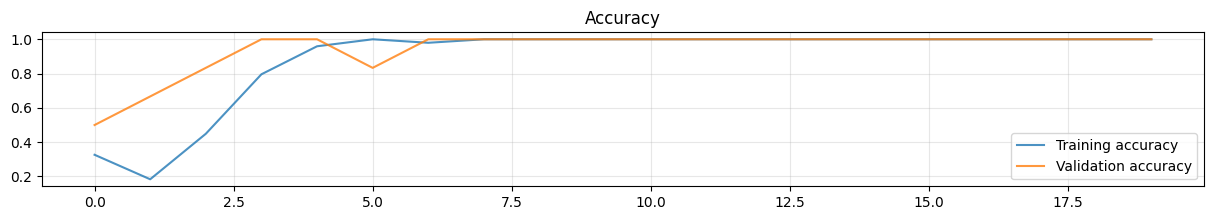

In [ ]:
# Plot training e validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training e validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

## Uso il modello
Utilizzo il modello sul dataset di training di "mars_for_students.npz" per classificare le immagini.

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ Input (InputLayer)                  │ (None, 64, 128, 1)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv1 (Conv2D)                      │ (None, 64, 128, 16)          │           416 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act1 (Activation)                   │ (None, 64, 128, 16)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp1 (MaxPooling2D)                  │ (None, 32, 64, 16)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv2 (Conv2D)                      │ (None, 32, 64, 32)           │         4,640 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act2 (Activation)                   │ (None, 32, 64, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp2 (MaxPooling2D)                  │ (None, 16, 32, 32)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ conv3 (Conv2D)                      │ (None, 16, 32, 64)           │        18,496 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ act3 (Activation)                   │ (None, 16, 32, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ mp3 (MaxPooling2D)                  │ (None, 8, 16, 64)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ flatten (Flatten)                   │ (None, 8192)                 │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ dense (Dense)                       │ (None, 2)                    │        16,386 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ softmax (Activation)                │ (None, 2)                    │             0 │    -    │
└─────────────────────────────────────┴──────────────────────────────┴───────────────┴─────────┘

 Total params: 119,816 (468.04 KB)

 Trainable params: 39,938 (156.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 79,878 (312.03 KB)

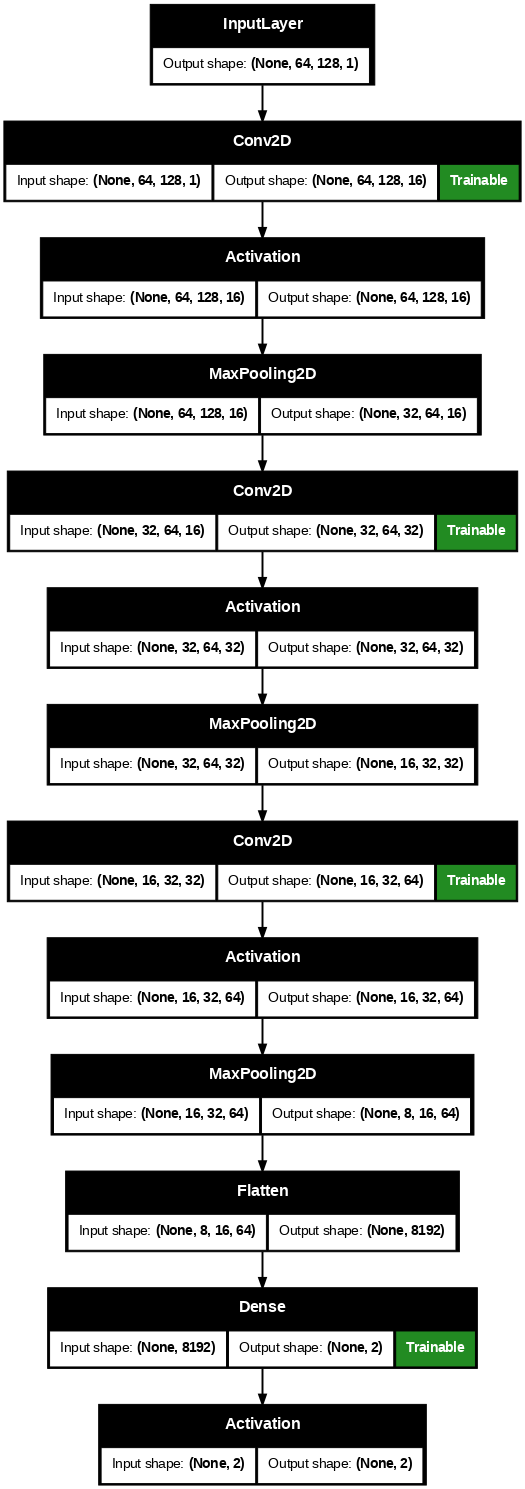

In [ ]:
# uso il modello per dividere le immagini del suolo da quelle degli alieni

# carico il modello
model = tfk.models.load_model('Alien_detector100.0.keras')

# Summary
model.summary(expand_nested=True, show_trainable=True)

# Architettura
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [ ]:
# applico la rete al dataset per pulirlo

classification = model.predict(X_train, verbose=0)
print("Predictions Shape:", classification.shape)

Predictions Shape: (2615, 2)


Numero di predizioni con label 1: 117


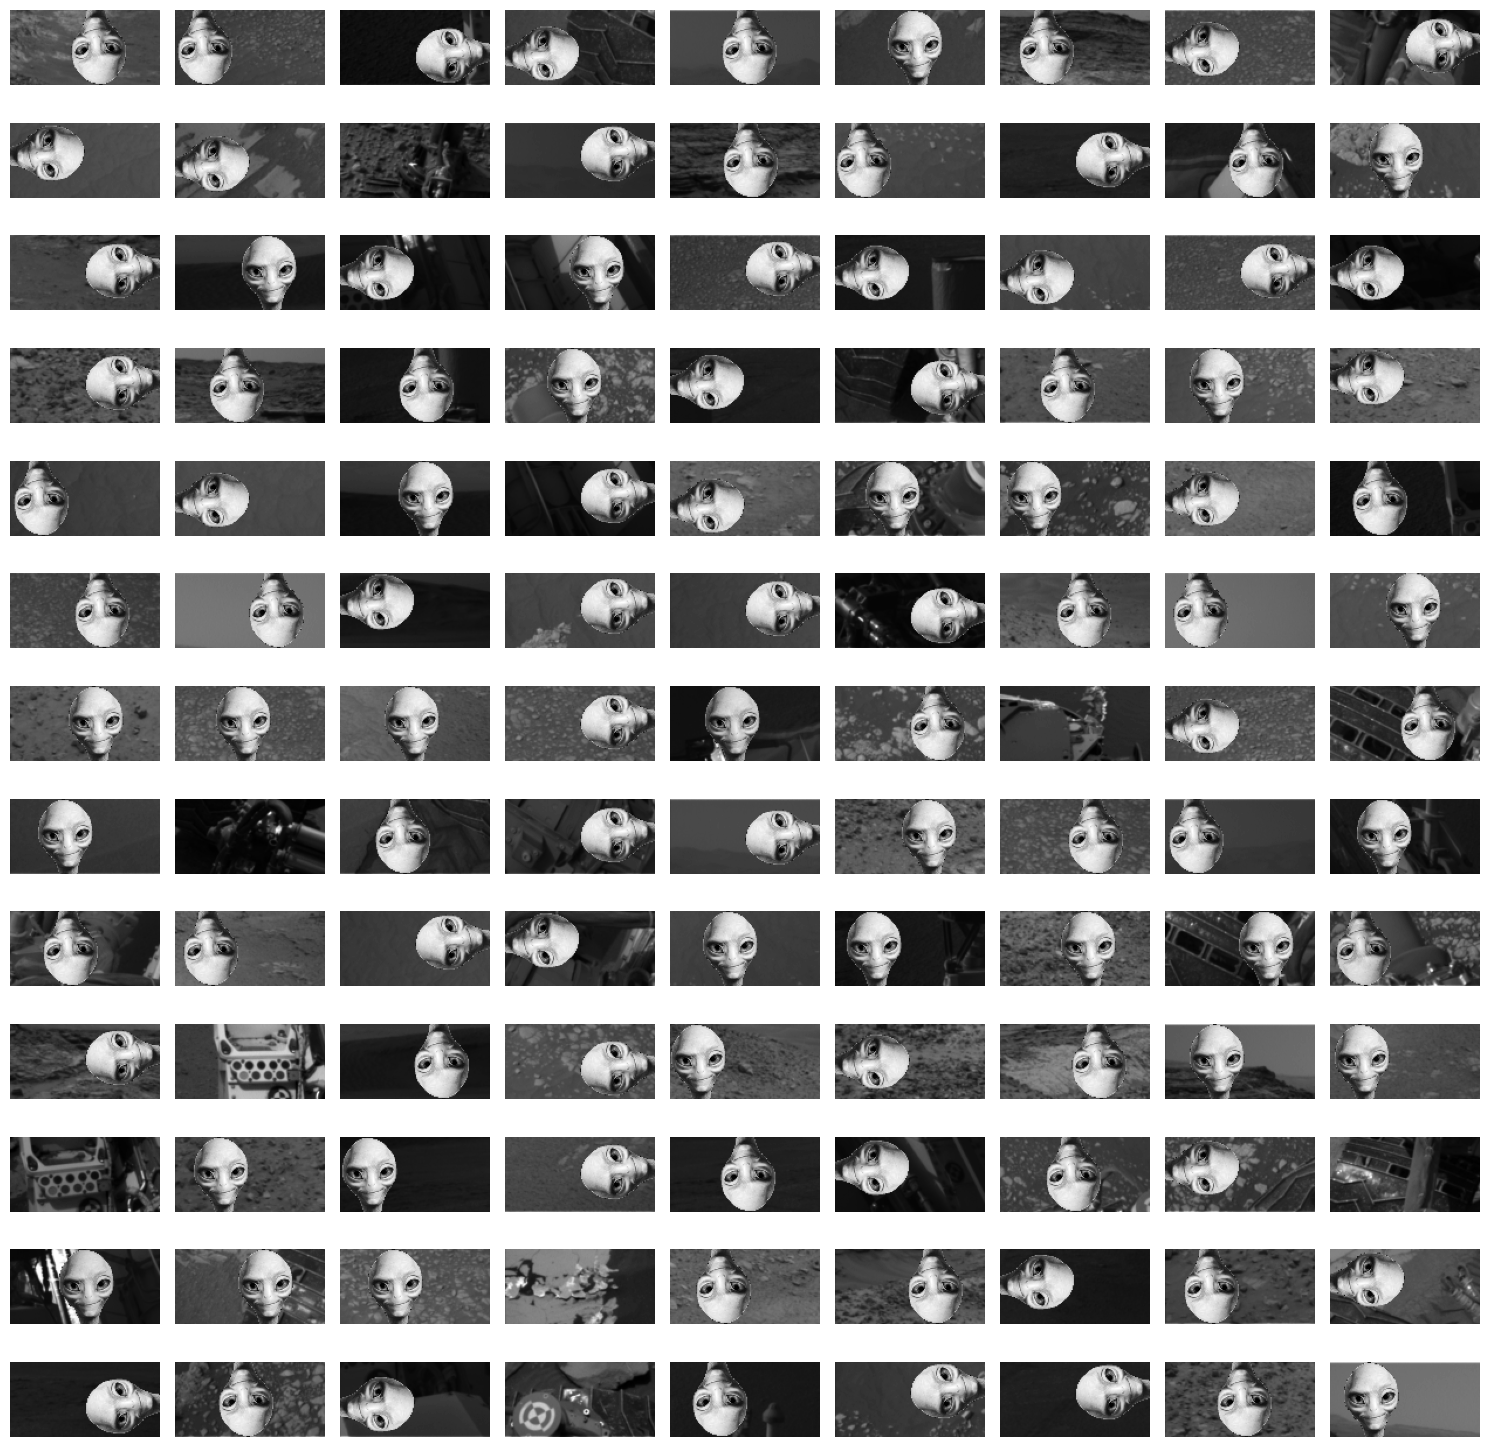

In [ ]:
# Immagini classificate come 1
# Trova le righe in cui la probabilità per label 1 è MAGGIORE di 0.1

label_indices = np.where(classification[:, 1] > 0.1)[0] # Indici con P(label=1)
alien_images = X_train[label_indices] # Estraggo quelle righe

# Stampa dei campioni
print(f"Numero di predizioni con label 1: {len(alien_images)}")

fig, axes = plt.subplots(13, 9, figsize=(15, 15))
axes = axes.flatten()
# Iteriamo sulle immagini selezionate
for i in range(len(alien_images)):
    ax = axes[i]
    ax.imshow(alien_images[i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

Numero di predizioni con label 1: 2498


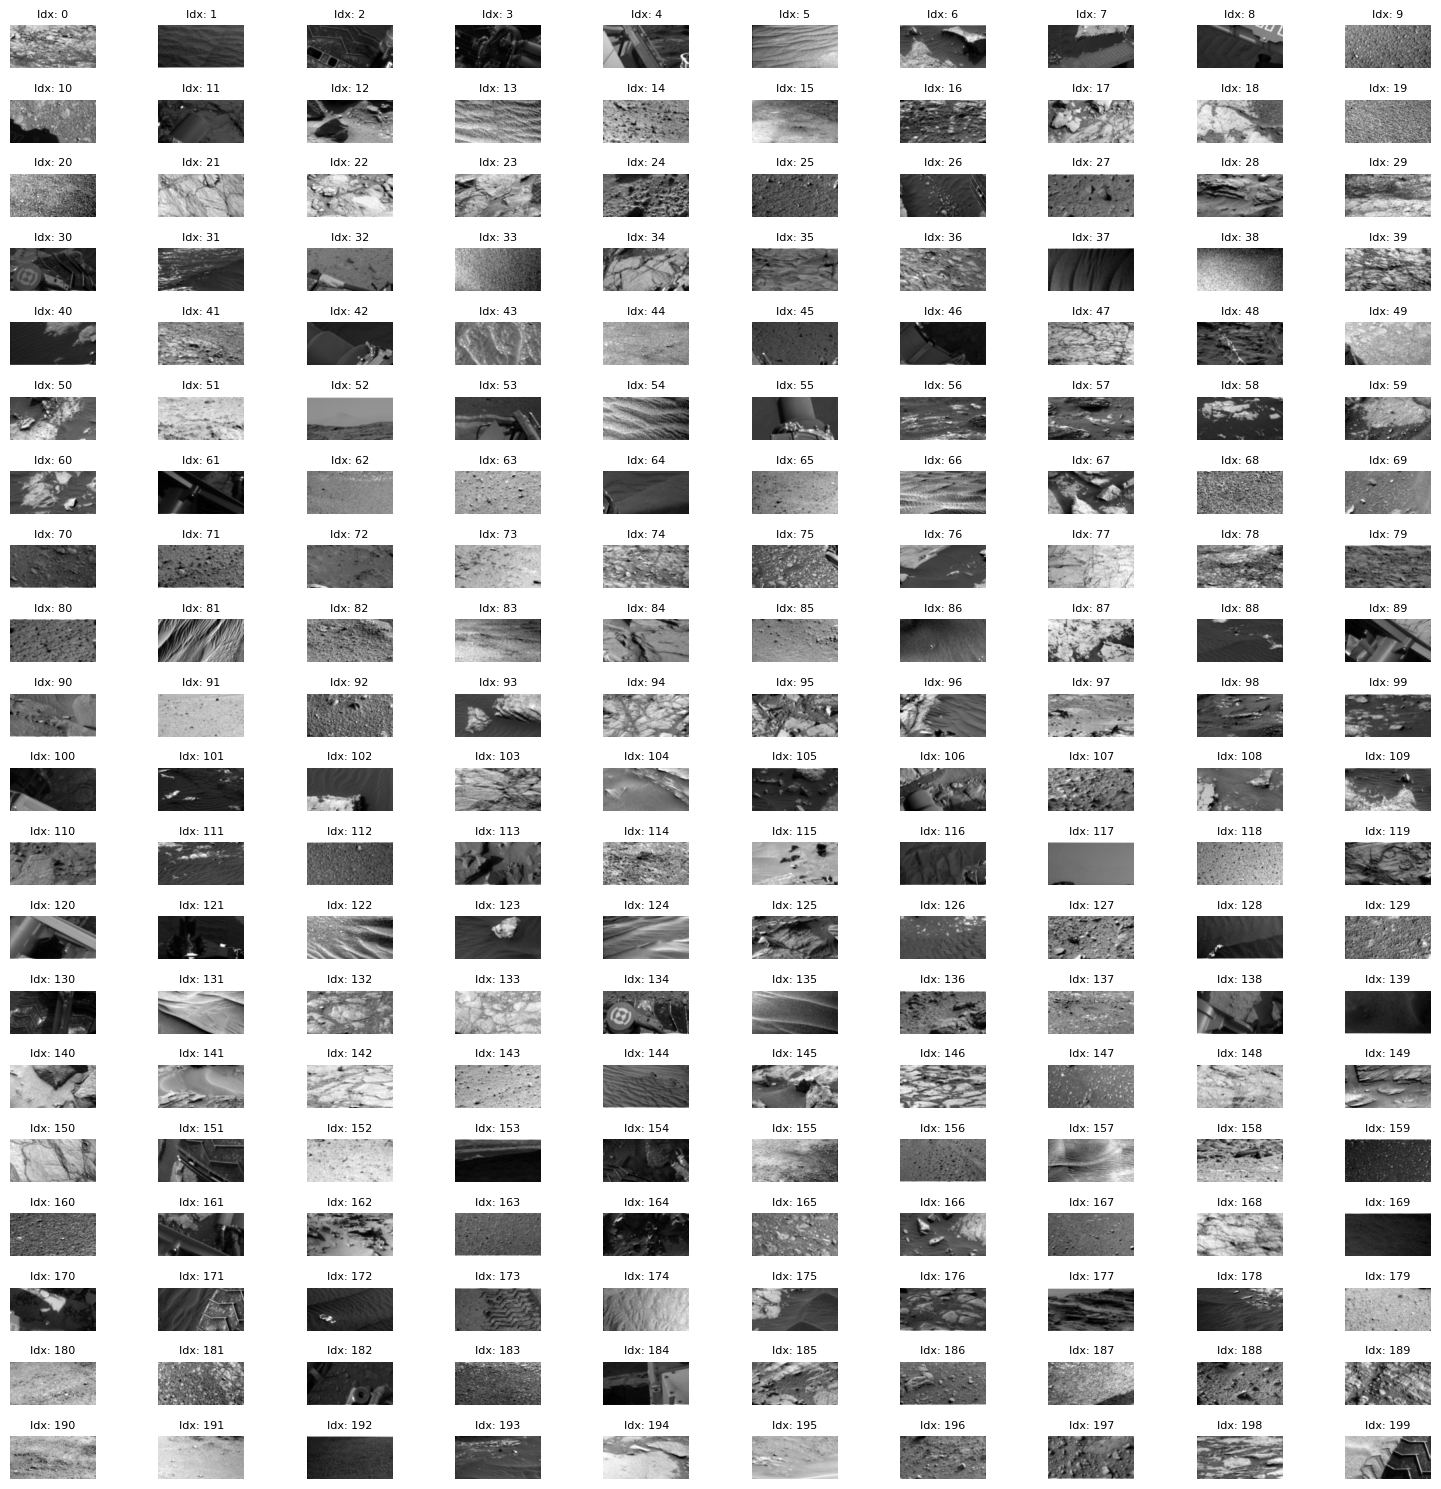

In [ ]:
# Campioni immagini classificate come 0
# Trova le righe in cui la probabilità per label 1 è MINORE O UGUALE a 0.1

label_indices = np.where(classification[:, 1] <= 0.1)[0] # Indici con P(label=1)
mars_images = X_train[label_indices] # Estraggo quelle immagini
mars_masks = y_train[label_indices] # Estraggo le rispettive maschere

# Stampa dei campioni
print(f"Numero di predizioni con label 1: {len(mars_images)}")

fig, axes = plt.subplots(20, 10, figsize=(15, 15))
axes = axes.flatten()

for i in range(200):
    ax = axes[i]
    ax.imshow(mars_images[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f"Idx: {i}", fontsize=8)

plt.tight_layout()
plt.show()

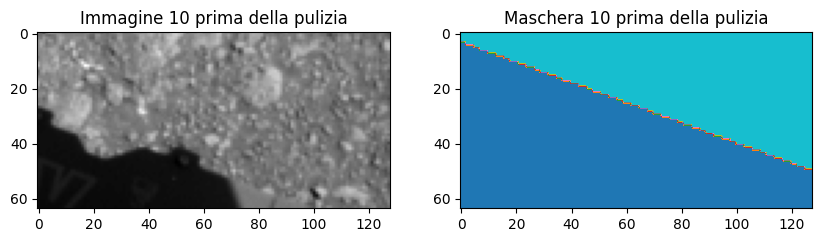

In [ ]:
# Seleziona un esempio immagine + maschera prima e dopo la pulizia per verificare la corrispondenza
idx = 10

# Visualizza immagine e maschera
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(X_train[idx], cmap="gray")
plt.title("Immagine 10 prima della pulizia")

plt.subplot(1, 2, 2)
plt.imshow(y_train[idx], cmap="tab10")
plt.title("Maschera 10 prima della pulizia")

plt.show()

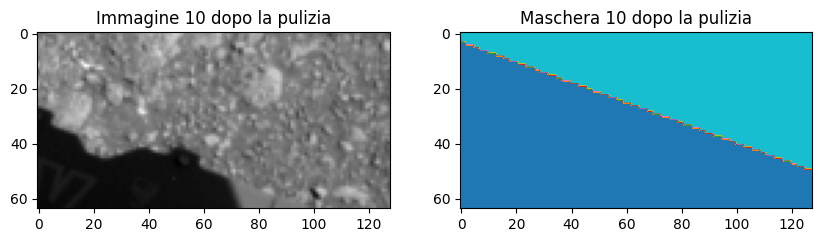

In [ ]:
# Visualizza immagine e maschera
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(mars_images[idx], cmap="gray")
plt.title("Immagine 10 dopo la pulizia")

plt.subplot(1, 2, 2)
plt.imshow(mars_masks[idx], cmap="tab10")
plt.title("Maschera 10 dopo la pulizia")

plt.show()

**Osservazione:** l'immagine e la maschera relativa corrispondono. Dataset gestito bene.

In [ ]:
# Salva le immagini con label 0 e le rispettive maschere in un file npz
np.savez('cleaned_mars.npz', images = mars_images, masks = mars_masks)

# Verifica che il file sia stato salvato correttamente
print("File 'cleaned_mars.npz' salvato.")

File 'cleaned_mars.npz' salvato.


**Osservazione:** il dataset nella cartella è stato rinominato come "cleaned_dataset_CNN.npz"